<a href="https://colab.research.google.com/github/D1emonk/My-repo/blob/main/Lesson_34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.impute import SimpleImputer
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [31]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/hour_online.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
df.head(10)

,Time,Users
0,1/1/17 0:00,34002
1,1/1/17 1:00,37947
2,1/1/17 2:00,41517
3,1/1/17 3:00,44476
4,1/1/17 4:00,46234
5,1/1/17 5:00,48842
6,1/1/17 6:00,52245
7,1/1/17 7:00,55245
8,1/1/17 8:00,57725
9,1/1/17 9:00,59534


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625 entries, 0 to 2624
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Time    2625 non-null   object
 1   Users   2625 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 41.1+ KB


In [34]:
# Проверка пропусков
df.isna().sum()

,0
Time,0
Users,0


In [4]:
# Заполнение пропусков средним
if df.isna().sum().sum() > 0:
    imputer = SimpleImputer(strategy='mean')
    df[df.columns] = imputer.fit_transform(df)

In [47]:
result = adfuller(df['Users'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Value ({}): {:.3f}'.format(key, value))

if result[1] < 0.05:
    print("Ряд стационарен.")
else:
    print("Ряд нестационарен, требуется дифференцирование.")

ADF Statistic: -2.2453790321361384
p-value: 0.19018943960897744
Critical Value (1%): -3.433
Critical Value (5%): -2.863
Critical Value (10%): -2.567
Ряд нестационарен, требуется дифференцирование.


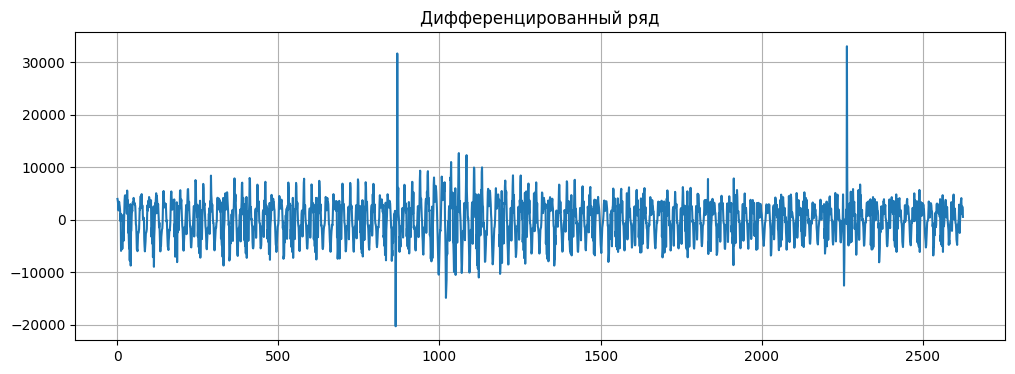

In [48]:
df['Users_diff'] = df['Users'].diff()
df['Users_diff'].dropna().plot(figsize=(12, 4), title='Дифференцированный ряд')
plt.grid()
plt.show()

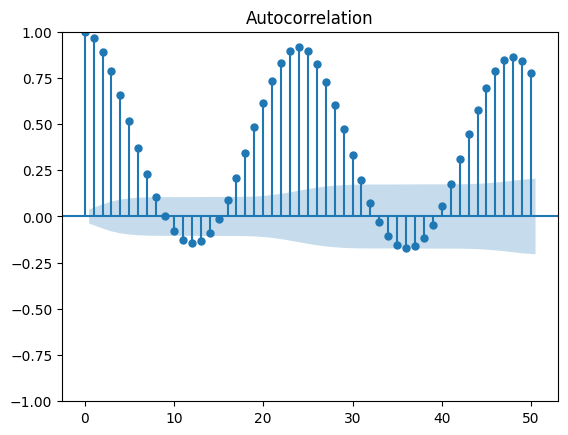

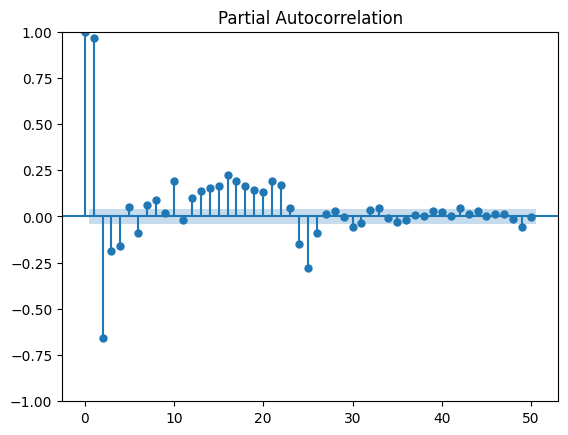

In [55]:
# оригинальный временной ряд
plot_acf(df['Users'].dropna(), lags=50)
plt.show()

plot_pacf(df['Users'].dropna(), lags=50)
plt.show()

Для ACF характерен волнообразный (синусоидальный) паттерн, который медленно затухает, что означет типичный признак сезонности. На pacf сильный пик на лаге 1, с постепенным затуханием. Нет чёткого обрыва после 1–2 лага, значит нет ярко выраженного AR-порядка. От сюда можно сделать вывод, что значения с p=1 или p=2 могут подойти для ARIMА

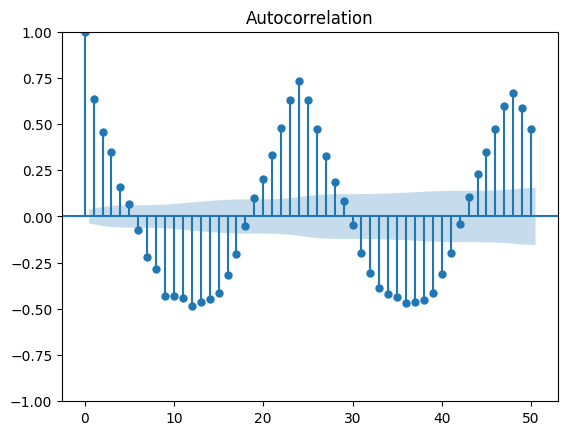

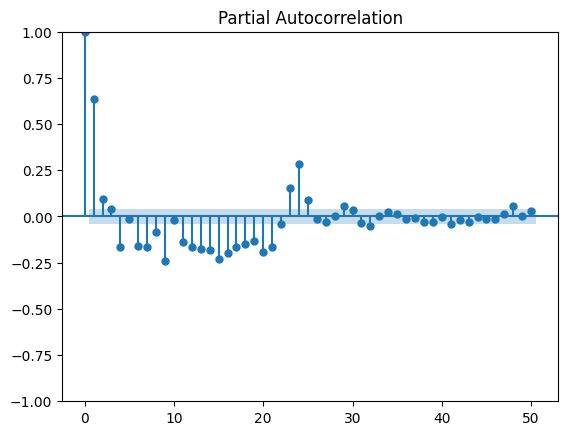

In [57]:
# Дифференцированный временной ряд
plot_acf(df['Users_diff'].dropna(), lags=50)
plt.show()

plot_pacf(df['Users_diff'].dropna(), lags=50)
plt.show()

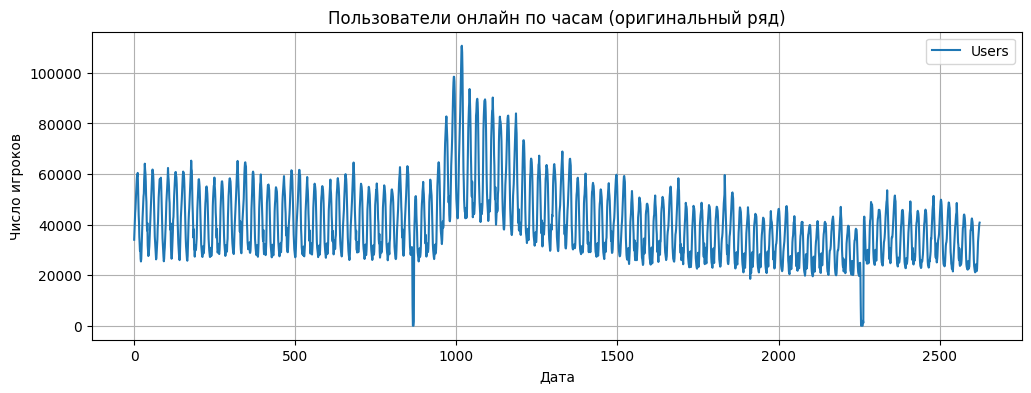

In [5]:
# Визуализация исходного временного ряда
plt.figure(figsize=(12, 4))
sns.lineplot(data=df)
plt.title("Пользователи онлайн по часам (оригинальный ряд)")
plt.xlabel("Дата")
plt.ylabel("Число игроков")
plt.grid(True)
plt.show()

In [62]:
# 3. Скользящее среднее (24 часа)
df['RollingMean_24h'] = df['Users'].rolling(window=24).mean()

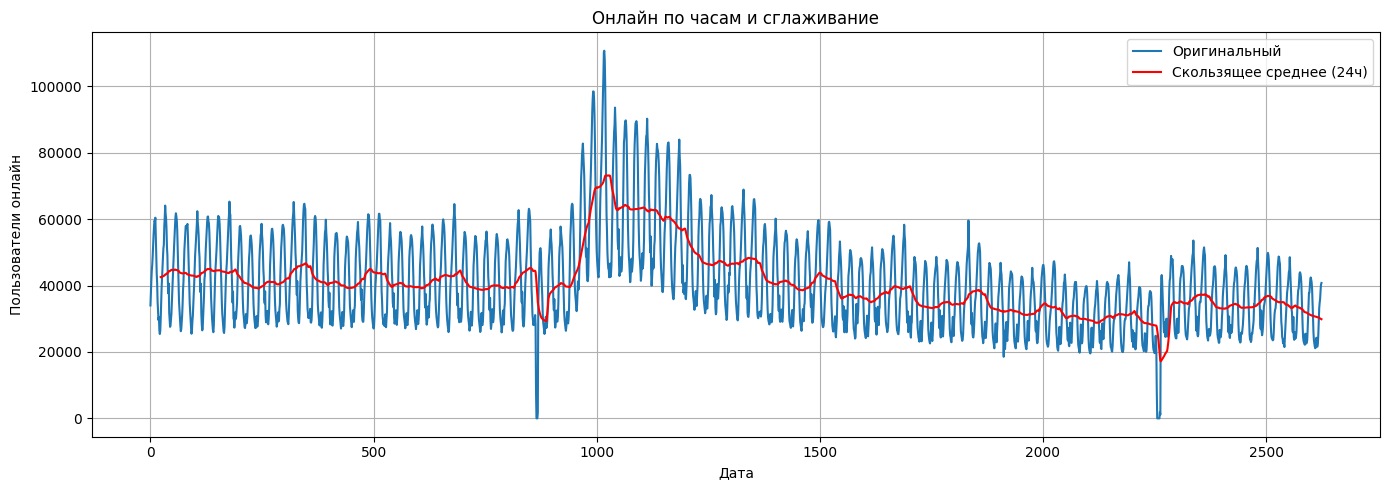

In [7]:
# Оригинальный + скользящее среднее
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Users'], label='Оригинальный')
plt.plot(df.index, df['RollingMean_24h'], label='Скользящее среднее (24ч)', color='red')
plt.title('Онлайн по часам и сглаживание')
plt.xlabel('Дата')
plt.ylabel('Пользователи онлайн')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
# 3. Скользящее среднее Дифференцированное  (24 часа)
df['Rollin_24h'] = df['Users_diff'].rolling(window=24).mean()

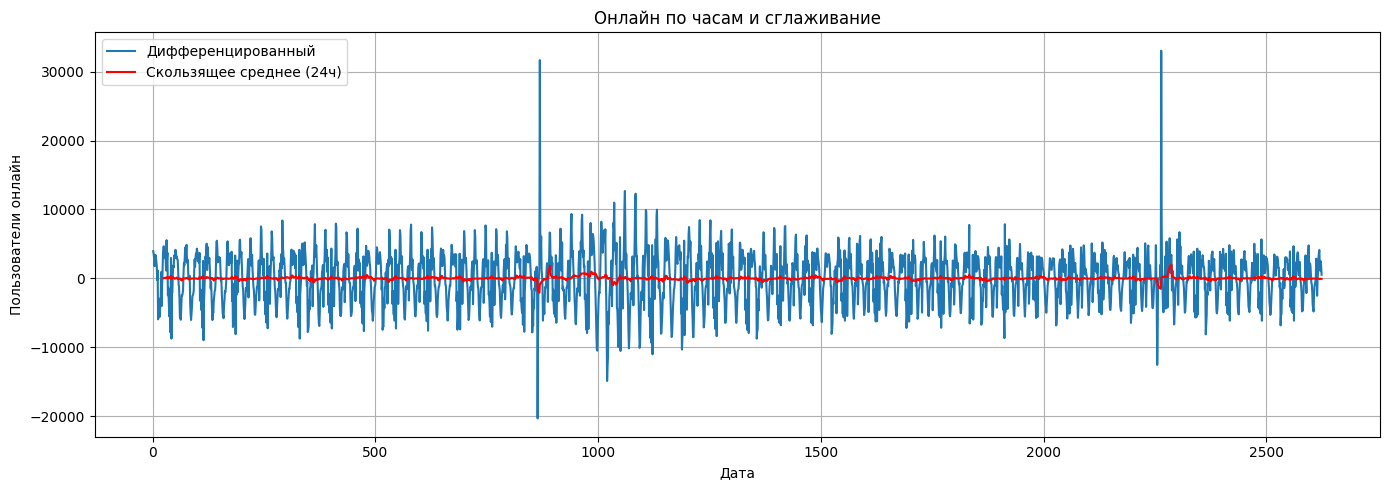

In [64]:
# Дифференцированный + скользящее среднее
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['Users_diff'], label='Дифференцированный')
plt.plot(df.index, df['Rollin_24h'], label='Скользящее среднее (24ч)', color='red')
plt.title('Онлайн по часам и сглаживание')
plt.xlabel('Дата')
plt.ylabel('Пользователи онлайн')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<h3> Прогноз на оригинальном временном ряде

In [67]:
# 1. Обрезка 168 часов (7дней)
forecast_horizon = 168
train = df.iloc[:-forecast_horizon]
test = df.iloc[-forecast_horizon:]

In [23]:
# 2. Обучаем модель на тренировочной части
model_cut = ARIMA(train['Users'], order=(3, 1, 3))
model_cut_fit = model_cut.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
# 3. Прогноз на горизонт
forecast_cut = model_cut_fit.forecast(steps=forecast_horizon)

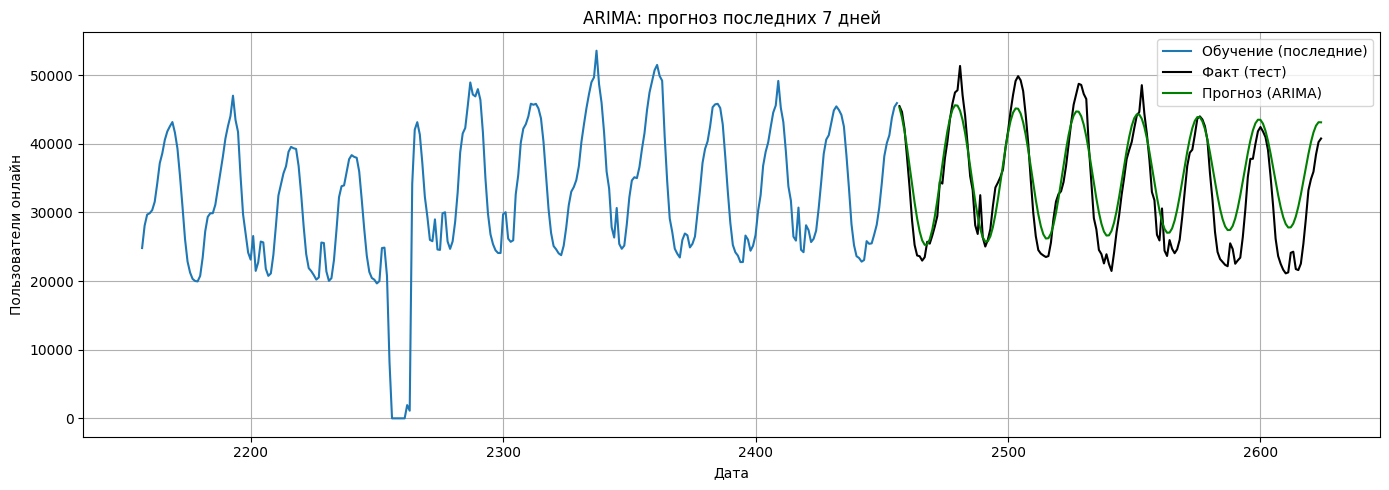

In [43]:
# 4. Визуализация: сравнение прогноза с фактом
plt.figure(figsize=(14, 5))
plt.plot(train.index[-300:], train['Users'].iloc[-300:], label='Обучение (последние)')
plt.plot(test.index, test['Users'], label='Факт (тест)', color='black')
plt.plot(test.index, forecast_cut, label='Прогноз (ARIMA)', color='green')
plt.title('ARIMA: прогноз последних 7 дней')
plt.xlabel('Дата')
plt.ylabel('Пользователи онлайн')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
mae = mean_absolute_error(test['Users'], forecast_cut)
rmse = np.sqrt(mean_squared_error(test['Users'], forecast_cut))
mae, rmse

(14469.05383016051, np.float64(16695.324837717606))

<h3> Прогноз на дифференцированном временном ряде


In [68]:
# 1. Обрезка 168 часов (7дней)
forecast_horizon_diff = 168
train_diff = df.iloc[:-forecast_horizon_diff]
test_diff = df.iloc[-forecast_horizon_diff:]

In [76]:
# 2. Обучаем модель на тренировочной части
model_diff = ARIMA(train_diff['Users_diff'], order=(3, 1, 3))
model_diff_fit = model_diff.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [74]:
# 3. Прогноз на горизонт
forecast_cut_diff = model_diff_fit.forecast(steps=forecast_horizon_diff)
forecast_cut_diff.index = test_diff.index

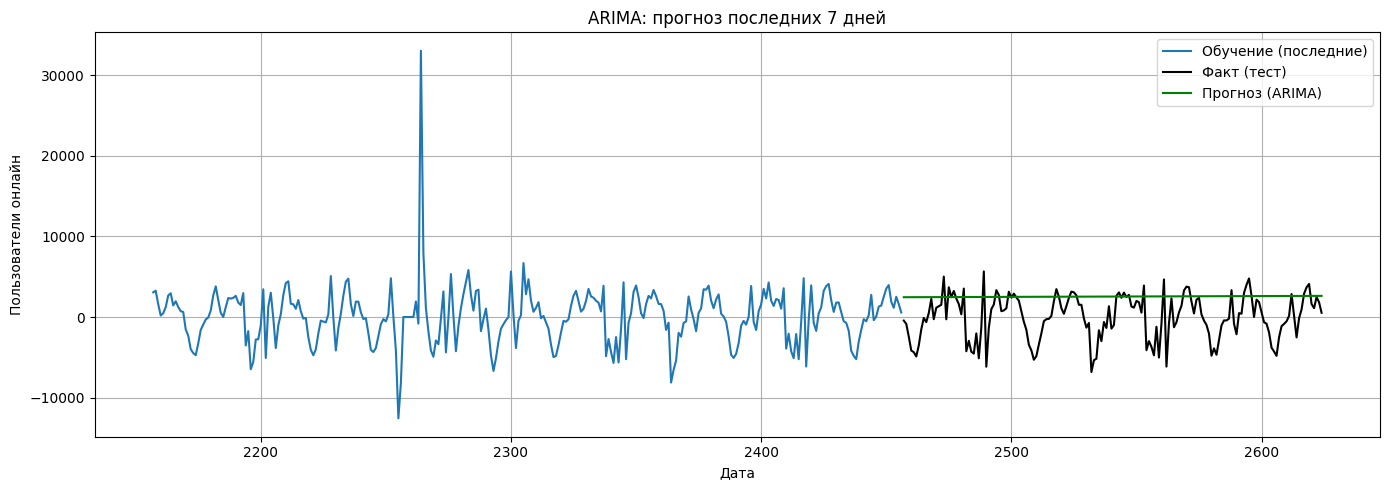

In [78]:
# 4. Визуализация: сравнение прогноза с фактом
plt.figure(figsize=(14, 5))
plt.plot(train.index[-300:], train_diff['Users_diff'].iloc[-300:], label='Обучение (последние)')
plt.plot(test_diff.index, test_diff['Users_diff'], label='Факт (тест)', color='black')
plt.plot(test_diff.index, forecast_cut_diff.index, label='Прогноз (ARIMA)', color='green')
plt.title('ARIMA: прогноз последних 7 дней')
plt.xlabel('Дата')
plt.ylabel('Пользователи онлайн')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<h3> LSTM

In [13]:
# Подготовка данных
data = df[['Users']].values

In [14]:
# Нормализация
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [15]:

# Используем последние 1000 точек для ускорения обучения
n_total = 1000
scaled_data = scaled_data[-n_total:]

In [16]:
# Параметры окна
look_back = 24  # 1 день
X, y = [], []

for i in range(look_back, len(scaled_data)):
    X.append(scaled_data[i - look_back:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

In [17]:
# Преобразование для LSTM (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [18]:
# Разделение на train/test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [19]:
# Создание LSTM модели
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(look_back, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
# Обучение модели
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

In [21]:
# Прогноз
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


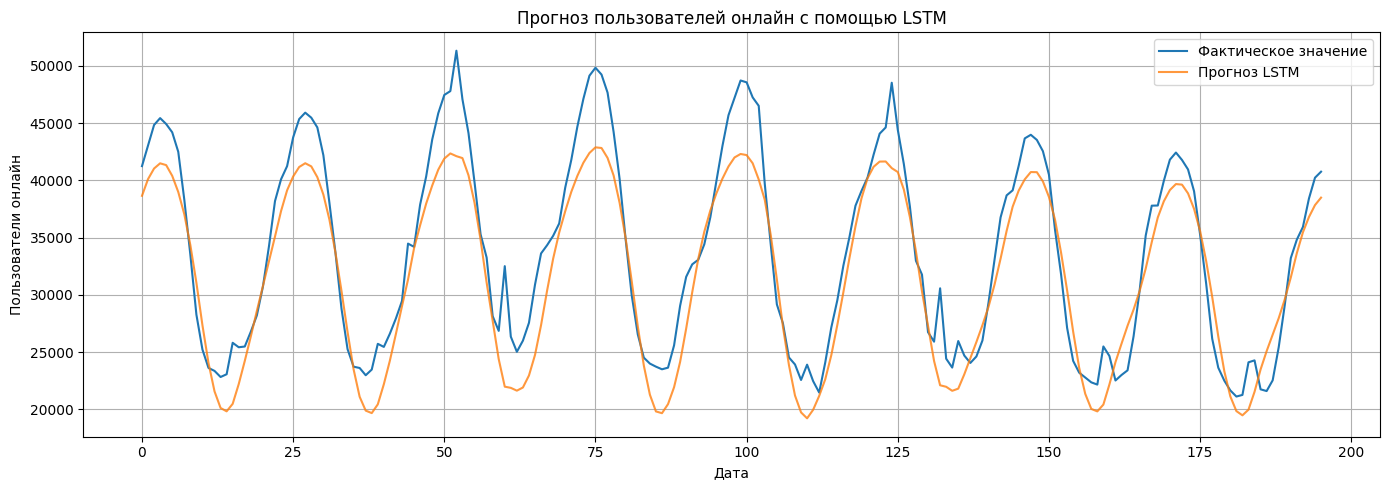

In [22]:
# Визуализация
plt.figure(figsize=(14, 5))
plt.plot(y_test_inv, label='Фактическое значение')
plt.plot(y_pred_inv, label='Прогноз LSTM', alpha=0.8)
plt.title('Прогноз пользователей онлайн с помощью LSTM')
plt.xlabel('Дата')
plt.ylabel('Пользователи онлайн')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
